<a href="https://colab.research.google.com/github/swilsonmfc/bias_variance/blob/main/Ensembling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensembling

# Install

In [1]:
!pip install catboost

     |████████████████████████████████| 69.2MB 42kB/s 


In [2]:
!pip install mlens

     |████████████████████████████████| 235kB 14.8MB/s 


In [3]:
!pip install category_encoders

     |████████████████████████████████| 81kB 6.1MB/s 


# Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

import catboost as cat
import lightgbm as lgb
import xgboost  as xgb

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from mlens.ensemble import SuperLearner

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix

from category_encoders import OneHotEncoder

[MLENS] backend: threading
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Kaggle

In [5]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
!kaggle datasets download -d usdot/flight-delays

 93% 177M/191M [00:02<00:00, 61.2MB/s]
100% 191M/191M [00:03<00:00, 66.2MB/s]


In [7]:
!unzip flight-delays.zip

Archive:  flight-delays.zip
  inflating: airlines.csv            
  inflating: airports.csv            
  inflating: flights.csv             


In [8]:
!ls

airlines.csv  airports.csv  flight-delays.zip  flights.csv  sample_data


# Data

In [9]:
flight_df  = pd.read_csv('./flights.csv')
airport_df = pd.read_csv('./airports.csv')
airline_df = pd.read_csv('./airlines.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
flight_df.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object

In [11]:
flight_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
airport_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [13]:
airline_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


# Processing

In [14]:
df = flight_df.copy()

## JFK Departures

In [15]:
df = df[df.ORIGIN_AIRPORT == 'JFK']
df.shape

(93811, 31)

## Features

In [16]:
keep_cols = ['MONTH',
            'DAY_OF_WEEK',
            'AIRLINE',
            'DESTINATION_AIRPORT',
            'SCHEDULED_DEPARTURE',
            'SCHEDULED_ARRIVAL',
            'SCHEDULED_TIME',
            'DISTANCE',
            'ARRIVAL_DELAY',
            'CANCELLED'
]
df = df[keep_cols].copy()

## Missing

In [17]:
missing_df = pd.DataFrame(df.isna().mean().round(4) * 100)
missing_df.reset_index().rename(columns={'index': 'Feature', 0: 'Percent Missing'})

,Feature,Percent Missing
0,MONTH,0.00
1,DAY_OF_WEEK,0.00
2,AIRLINE,0.00
3,DESTINATION_AIRPORT,0.00
4,SCHEDULED_DEPARTURE,0.00
5,SCHEDULED_ARRIVAL,0.00
6,SCHEDULED_TIME,0.00
7,DISTANCE,0.00
8,ARRIVAL_DELAY,2.29
9,CANCELLED,0.00


In [18]:
df = df.dropna()

## Classification

In [19]:
## Balance Classes
delay  = df[df.ARRIVAL_DELAY > 0].sample(15000)
ontime = df[df.ARRIVAL_DELAY <= 0].sample(15000)
df = pd.concat([delay, ontime])

In [20]:
df['CLASS'] = np.where(df.ARRIVAL_DELAY <= 0, 'ONTIME', 'DELAY')

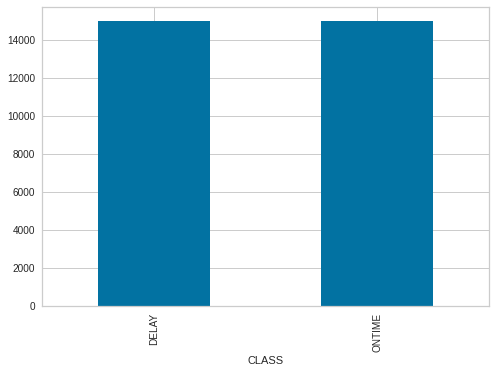

In [21]:
df.groupby('CLASS').size().plot.bar();

# EDA

## Top Arrival Airports & Airlines

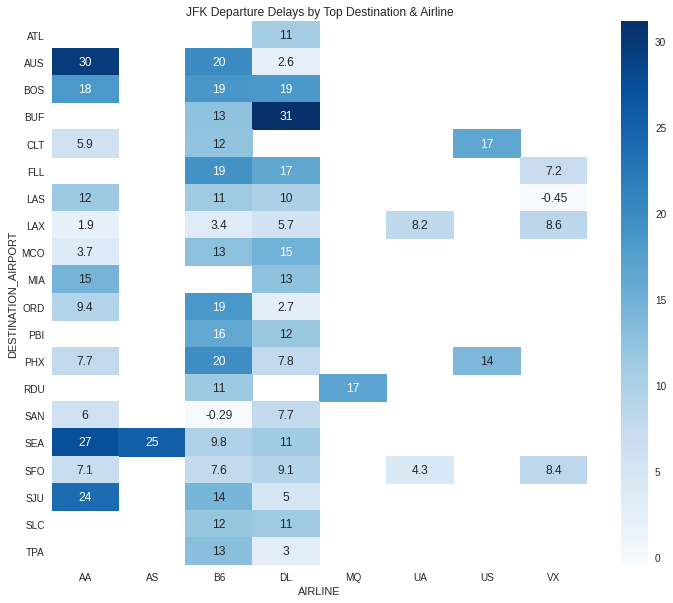

In [22]:
top = 20
topAirports = df.groupby('DESTINATION_AIRPORT').size() \
    .sort_values(ascending=False) \
    .head(top) \
    .index \
    .tolist()

pvt = df[df.DESTINATION_AIRPORT.isin(topAirports)] \
    .groupby(['AIRLINE', 'DESTINATION_AIRPORT']) \
    .agg({'ARRIVAL_DELAY': 'mean'}) \
    .reset_index() \
    .pivot(index='DESTINATION_AIRPORT', columns='AIRLINE', values='ARRIVAL_DELAY')

plt.figure(figsize=(12,10))
plt.title('JFK Departure Delays by Top Destination & Airline')
sns.heatmap(pvt, cmap='Blues', annot=True)
plt.yticks(rotation=0);

## Airline Delay Distribution


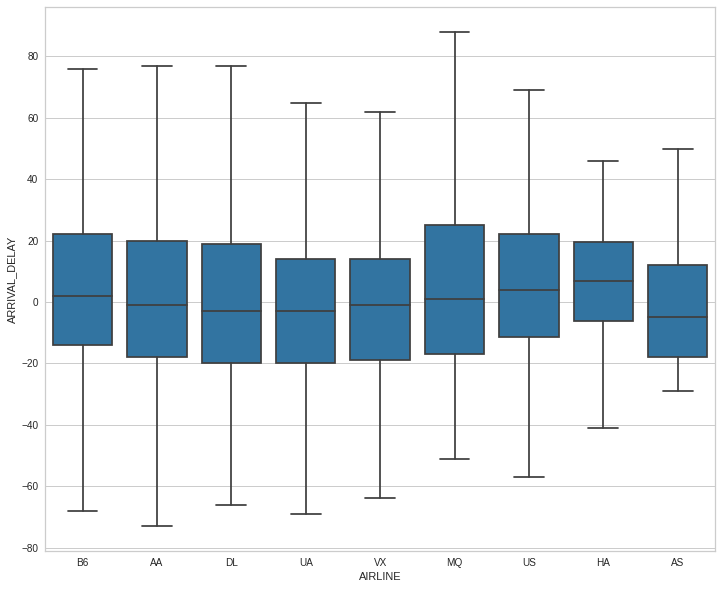

In [23]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.AIRLINE, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            color='#1f77b4');

## Delays by Month

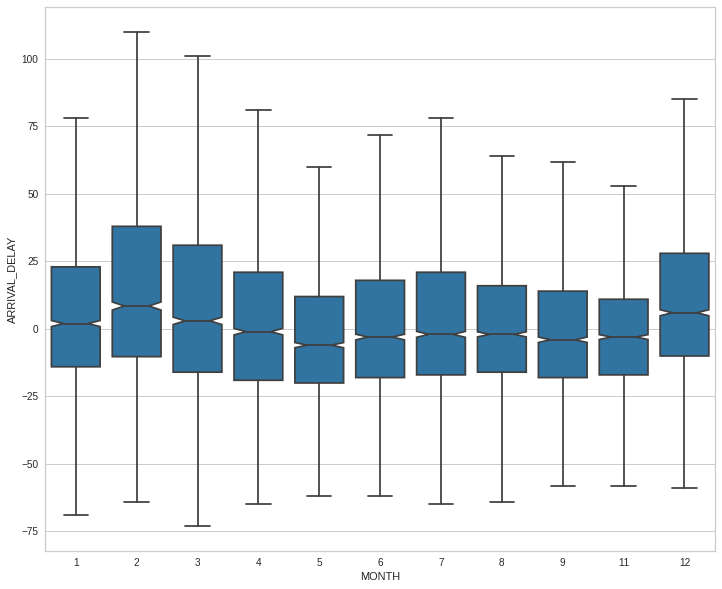

In [24]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.MONTH, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            notch=True,
            color='#1f77b4');

## Delays by Day of Week

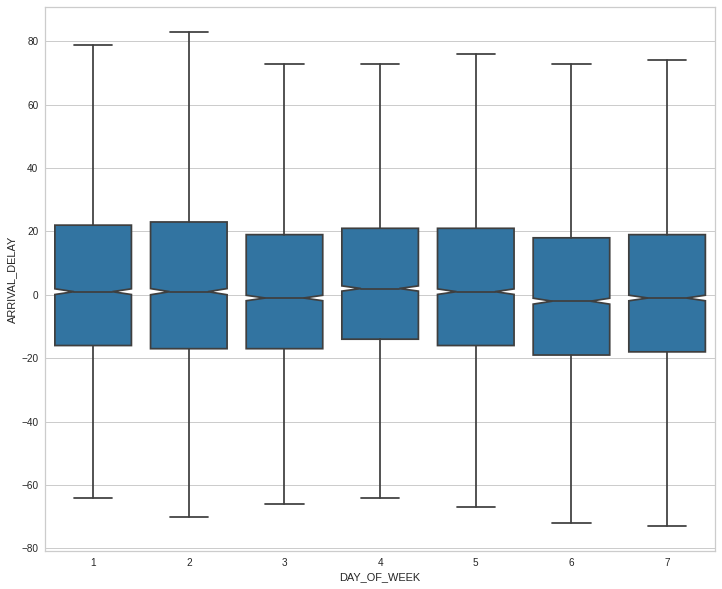

In [25]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.DAY_OF_WEEK, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            notch=True,
            color='#1f77b4');

## Distance

<Figure size 1080x864 with 0 Axes>

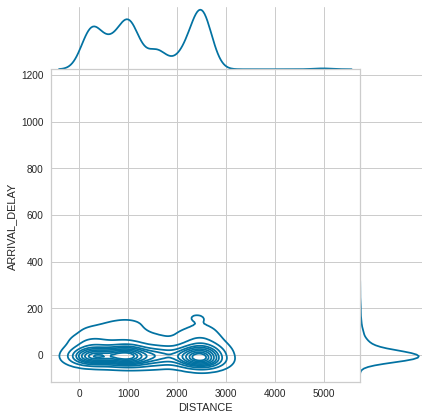

In [26]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot(x='DISTANCE', y='ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b');

## Scheduled Departure

<Figure size 1080x864 with 0 Axes>

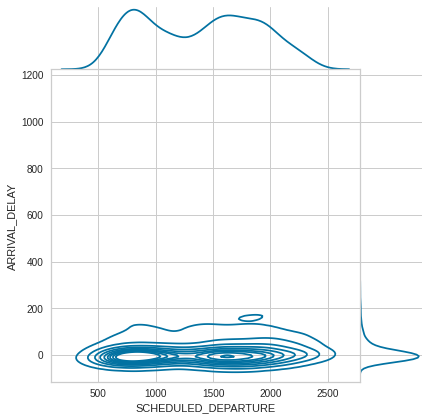

In [27]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot(x='SCHEDULED_DEPARTURE', y='ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b');

## Scheduled Arrival

<Figure size 1080x864 with 0 Axes>

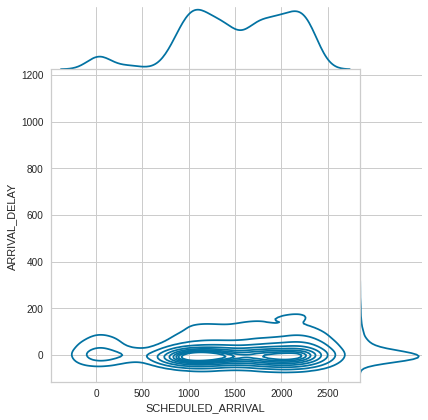

In [28]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot(x='SCHEDULED_ARRIVAL', y='ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b');

## Scheduled Time

<Figure size 1080x864 with 0 Axes>

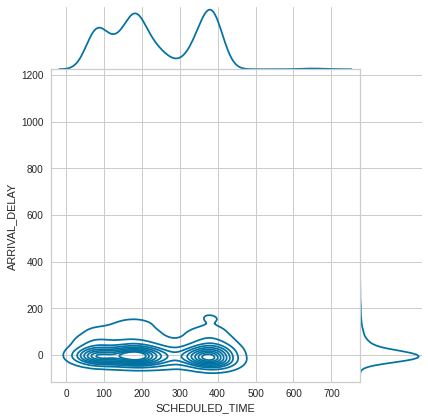

In [29]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot(x='SCHEDULED_TIME', y='ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b');

# Pipeline

In [30]:
df.dtypes

MONTH                    int64
DAY_OF_WEEK              int64
AIRLINE                 object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_ARRIVAL        int64
SCHEDULED_TIME         float64
DISTANCE                 int64
ARRIVAL_DELAY          float64
CANCELLED                int64
CLASS                   object
dtype: object

In [31]:
X = df.copy()
X = X.sample(frac=0.25, random_state=23)
X.MONTH       = X.MONTH.astype(str)
X.DAY_OF_WEEK = X.DAY_OF_WEEK.astype(str)
X.AIRLINE     = X.AIRLINE.astype(str)
X.DESTINATION_AIRPORT = X.DESTINATION_AIRPORT.astype(str)
print(X.dtypes)

y = X.CLASS
X = X.drop(['CLASS', 'CANCELLED', 'ARRIVAL_DELAY'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = np.where(y_train == 'ONTIME', 0, 1)
y_test  = np.where(y_test  == 'ONTIME', 0, 1)

MONTH                   object
DAY_OF_WEEK             object
AIRLINE                 object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_ARRIVAL        int64
SCHEDULED_TIME         float64
DISTANCE                 int64
ARRIVAL_DELAY          float64
CANCELLED                int64
CLASS                   object
dtype: object


In [32]:
ohe = OneHotEncoder(use_cat_names=True)
X_train_df = ohe.fit_transform(X_train)
X_test_df  = ohe.transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


# Metrics

In [33]:
def measureErrors(y, y_hat):
    accuracy = accuracy_score(y, y_hat)
    print('Accuracy', accuracy)
    print('Confusion Matrix')
    print(confusion_matrix(y, y_hat))
    print('Classification Report')
    print(classification_report(y_hat, y))
    return accuracy

In [34]:
results_df = pd.DataFrame(columns=['Accuracy'])

# Bagging

![](https://www.kdnuggets.com/wp-content/uploads/Budzik-fig1-ensemble-learning.jpg)

In [35]:
rf = RandomForestClassifier(n_estimators=10)
et = ExtraTreesClassifier(n_estimators=10)
knn = KNeighborsClassifier(n_neighbors=20)
svc = SVC(gamma='auto')
rg = RidgeClassifier()

classifiers = [rf, et, knn, rg, svc]

In [36]:
bagging_df = pd.DataFrame(columns=['Baseline Mean', 'Bagging Mean', 'Baseline Std', 'Bagging Std'])
np.random.seed(1337)
for clf in classifiers:
    print('Running {}'.format(clf.__class__.__name__))
    bags     = BaggingClassifier(clf, max_samples=0.4, max_features=.9, random_state=25)
    bagging  = cross_val_score(bags, X_train_df, y_train, cv=5, n_jobs=-1)
    baseline = cross_val_score(clf, X_train_df, y_train, cv=5, n_jobs=-1)
    bagging_df.loc[clf.__class__.__name__] = [baseline.mean(), bagging.mean(), baseline.std(), bagging.std()]
    
    print('Baseline : Mean {:.3f} Std {:.3f}'.format(baseline.mean(), baseline.std()))
    print('Bagging  : Mean {:.3f} Std {:.3f}\n'.format(bagging.mean(), bagging.std()))
    
    results_df.loc[clf.__class__.__name__] = [baseline.mean()]
    results_df.loc['Bagging-' + clf.__class__.__name__] = [bagging.mean()]


Running RandomForestClassifier
Baseline : Mean 0.564 Std 0.007
Bagging  : Mean 0.581 Std 0.017

Running ExtraTreesClassifier
Baseline : Mean 0.562 Std 0.009
Bagging  : Mean 0.575 Std 0.010

Running KNeighborsClassifier
Baseline : Mean 0.552 Std 0.011
Bagging  : Mean 0.542 Std 0.012

Running RidgeClassifier
Baseline : Mean 0.576 Std 0.016
Bagging  : Mean 0.575 Std 0.011

Running SVC
Baseline : Mean 0.554 Std 0.014
Bagging  : Mean 0.533 Std 0.008



# Baseline

In [37]:
bagging_df[['Baseline Mean', 'Baseline Std']].sort_values('Baseline Mean', ascending=False)

,Baseline Mean,Baseline Std
RidgeClassifier,0.576167,0.015755
RandomForestClassifier,0.563667,0.006595
ExtraTreesClassifier,0.562333,0.008521
SVC,0.554333,0.013626
KNeighborsClassifier,0.551500,0.011321


In [38]:
bagging_df['Difference Mean'] = bagging_df['Bagging Mean'] - bagging_df['Baseline Mean']
bagging_df['Difference Std']  = bagging_df['Bagging Std']  - bagging_df['Baseline Std']
bagging_df[['Bagging Mean', 'Bagging Std', 'Difference Mean', 'Difference Std']] \
    .sort_values('Bagging Mean', ascending=False)

,Bagging Mean,Bagging Std,Difference Mean,Difference Std
RandomForestClassifier,0.580500,0.016969,0.016833,0.010373
RidgeClassifier,0.575167,0.011023,-0.001000,-0.004732
ExtraTreesClassifier,0.574667,0.009525,0.012333,0.001004
KNeighborsClassifier,0.541500,0.011942,-0.010000,0.000621
SVC,0.533000,0.007934,-0.021333,-0.005692


# Pasting
* Take small chunks of the data
* Grow predictor on chunk
* Paste predictors together
* Differs from Bagging
  * Bagging Sample with Replacement
  * Pasting Sample without Replacement
* Useful when you data has no practical way to fit into memory
* See Brieman (https://link.springer.com/article/10.1023/A:1007563306331)

# Voting

In [39]:
voting_df = pd.DataFrame(columns=['Voting Mean', 'Voting Std'])
np.random.seed(25)
classifiers = [knn, svc, rg, rf, et] 
vclf = VotingClassifier(estimators=[('KNN', knn),
                                    ('SVC', svc),
                                    ('Ridge', rg),
                                    ('RF', rf),
                                    ('ET', et)], voting='hard')
for clf, label in zip([rf, et, knn, rg, svc, vclf],
                      ['RF', 'ET', 'KNN', 'Ridge', 'SVC', 'Ensemble']):
    scores = cross_val_score(clf, X_train_df, y_train, cv=5, scoring='accuracy')
    print('Accuracy: %0.3f (+/- %0.3f) [%s]' % (scores.mean(), scores.std(), label))
    voting_df.loc[label] = [scores.mean(), scores.std()]
    
    if label == 'Ensemble':
        results_df.loc['Voting-Ensemble' + clf.__class__.__name__] = [scores.mean()]
voting_df

Accuracy: 0.564 (+/- 0.008) [RF]
Accuracy: 0.562 (+/- 0.008) [ET]
Accuracy: 0.552 (+/- 0.011) [KNN]
Accuracy: 0.576 (+/- 0.016) [Ridge]
Accuracy: 0.554 (+/- 0.014) [SVC]
Accuracy: 0.584 (+/- 0.006) [Ensemble]


,Voting Mean,Voting Std
RF,0.563833,0.008038
ET,0.561667,0.008367
KNN,0.551500,0.011321
Ridge,0.576167,0.015755
SVC,0.554333,0.013626
Ensemble,0.583667,0.006205


# Stacking
* Add layers of classifiers
* Multiple layers are processed sequentially
* A meta layer sits on top of the ensemble & learns the best output
* Typically, a linear model is used for meta

![](https://www.kdnuggets.com/wp-content/uploads/Budzik-fig3-ensemble-learning.jpg)

# Super Learner Algorithm
* Given input matrix X (n cases, m features) and outcomes Y
* Take L base learners
* Specify meta learner
* K-Fold CV on each base learner
* Build new matrix Z from base learners
* Train meta learner on Z and y

In [40]:
stack_df = pd.DataFrame(columns=['Accuracy'])

lr = LogisticRegression(solver='lbfgs')

clfs = [
    ('KNN', knn),
    ('SVC', svc),
    ('Ridge', rg),
    ('RF', rf),
    ('ET', et)
]

best = [0.00, '']
name = ''
for level in range(2, 6):
    for group in combinations(clfs, level):
        ensemble = SuperLearner(scorer = accuracy_score, random_state = 1337, folds = 5)

        names       = []
        classifiers = []
        
        for clf in group:
            names.append(clf[0])
            classifiers.append(clf[1])
            
        name = '-'.join(names)   

        ensemble.add(classifiers) # <-- Note! You can pass in pipelines per classifier
        ensemble.add_meta(lr)
        ensemble.fit(X_train_df, y_train)
        preds = ensemble.predict(X_test_df)
        accuracy = accuracy_score(preds, y_test)

        if accuracy > best[0]:
            best[0] = accuracy
            best[1] = name

        stack_df.loc[name] = [accuracy]
        results_df.loc['Stacking-' + name] = [accuracy]
        print('Training: ', name)

Training:  KNN-SVC
Training:  KNN-Ridge
Training:  KNN-RF
Training:  KNN-ET
Training:  SVC-Ridge
Training:  SVC-RF
Training:  SVC-ET
Training:  Ridge-RF
Training:  Ridge-ET
Training:  RF-ET
Training:  KNN-SVC-Ridge
Training:  KNN-SVC-RF
Training:  KNN-SVC-ET
Training:  KNN-Ridge-RF
Training:  KNN-Ridge-ET
Training:  KNN-RF-ET
Training:  SVC-Ridge-RF
Training:  SVC-Ridge-ET
Training:  SVC-RF-ET
Training:  Ridge-RF-ET
Training:  KNN-SVC-Ridge-RF
Training:  KNN-SVC-Ridge-ET
Training:  KNN-SVC-RF-ET
Training:  KNN-Ridge-RF-ET
Training:  SVC-Ridge-RF-ET
Training:  KNN-SVC-Ridge-RF-ET


In [41]:
stack_df.sort_values('Accuracy', ascending=False)

,Accuracy
Ridge-RF-ET,0.597333
SVC-Ridge-RF,0.597333
KNN-Ridge-RF,0.594667
KNN-Ridge-RF-ET,0.594000
KNN-RF-ET,0.592000
KNN-SVC-Ridge-RF-ET,0.591333
KNN-Ridge-ET,0.590667
SVC-Ridge-RF-ET,0.589333
KNN-SVC-Ridge-RF,0.587333
SVC-RF-ET,0.585333


# Stacking + Feature Propagation
* Stacking layers usually reduces variance
* Base learners get better at predicting output
* Residual errors get harder to correct from multicollinearity
* We can reduce variance if we pass original features to meta learner
* We can use features in base and pass to meta
* We can pass features untouched by base

# Compare

In [42]:
results_df.sort_values('Accuracy', ascending=False)

,Accuracy
Stacking-Ridge-RF-ET,0.597333
Stacking-SVC-Ridge-RF,0.597333
Stacking-KNN-Ridge-RF,0.594667
Stacking-KNN-Ridge-RF-ET,0.594000
Stacking-KNN-RF-ET,0.592000
Stacking-KNN-SVC-Ridge-RF-ET,0.591333
Stacking-KNN-Ridge-ET,0.590667
Stacking-SVC-Ridge-RF-ET,0.589333
Stacking-KNN-SVC-Ridge-RF,0.587333
Stacking-SVC-RF-ET,0.585333


In [43]:
improve_df = results_df.copy()
improve_df['Improvement'] = (improve_df.Accuracy.max() - improve_df.Accuracy) * 100.0 / improve_df.Accuracy  
improve_df.sort_values('Improvement', ascending=False)

,Accuracy,Improvement
Bagging-SVC,0.533000,12.070044
Bagging-KNeighborsClassifier,0.541500,10.310865
KNeighborsClassifier,0.551500,8.310668
SVC,0.554333,7.757066
ExtraTreesClassifier,0.562333,6.224066
RandomForestClassifier,0.563667,5.972797
Stacking-KNN-SVC,0.570000,4.795322
Stacking-SVC-ET,0.572667,4.307334
Bagging-ExtraTreesClassifier,0.574667,3.944316
Bagging-RidgeClassifier,0.575167,3.853955


# Tips
* You typically won't get extremely large gains from ensembling
* Can be helpful in reducing variance
* Performs best when you have learners that are not highly correlated
* Not hard to implement many helpful libraries
  * mlens
  * pycaret
* Good base learners tend to be low bias, high variance (i.e. decision trees)